In [1]:
import sys
if not '..' in sys.path:
    sys.path.append('..')

In [2]:
from pathlib import Path
from analysis import collection
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

In [3]:
collection_name = "emg_olympics"
subject_names = collection.get_subject_names(collection_name)
print(f"{len(subject_names)} subjects in {collection_name}.")
c = collection.Collection(collection_name)

46 subjects in emg_olympics.


In [10]:
for s in c.subjects.values():
    for sesh in s.tasks["center_hold"].sessions.values():
        if len(sesh.trials) == 12:
            print("No Hold" in [t.outcome for t in sesh.trials.values()])

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [4]:
counts = {}
for s in subjects:
    counts[s.name] = []
    for session_num in range(45):
        # s.get_session_outcomes(collection_name, session_num)       
        session_counts = s.get_session_outcome_counts(collection_name, session_num)
        counts[s.name].append(session_counts)

created emg_olympics for aeron
created emg_olympics for alba
created emg_olympics for andrei


/Users/spencer/phd/phd/analysis/notebooks/../analysis/subject.py:149: UserWarning: genfromtxt: Empty input file: "<_io.StringIO object at 0x13dd50670>"
  self.behavior[collection_name][session_num_str] = np.genfromtxt(StringIO(blob.decode('utf-8')), delimiter=',', skip_header=1, dtype=None, encoding=None)


created emg_olympics for andy
created emg_olympics for april
created emg_olympics for arthur
created emg_olympics for billy
created emg_olympics for bob
created emg_olympics for chiyu
created emg_olympics for clem
created emg_olympics for dammy
created emg_olympics for daniel
created emg_olympics for egzona
created emg_olympics for elena
created emg_olympics for emmett
created emg_olympics for fede
created emg_olympics for georgia
created emg_olympics for hernando
created emg_olympics for holly
created emg_olympics for hyewon
created emg_olympics for ivana
created emg_olympics for jai
created emg_olympics for jesse
created emg_olympics for lara
created emg_olympics for lars
created emg_olympics for lucas
created emg_olympics for marta
created emg_olympics for mattias
created emg_olympics for miranda
created emg_olympics for morio
created emg_olympics for nate
created emg_olympics for nicole
created emg_olympics for oriol
created emg_olympics for peterg
created emg_olympics for peterv
c

### counting numbers of hits

In [5]:
# limited to the first 45, no special skipped blocks, etc.
hit_sums = {}
for name in counts.keys():
    hit_sums[name] = sum([sesh["hits"] for sesh in counts[name]])

sorted_hit_sums = sorted(hit_sums.items(), key = lambda e: e[1])

most_hit_subject = sorted_hit_sums[-1][0]
most_hits = sorted_hit_sums[-1][1]

least_hit_subject = sorted_hit_sums[0][0]
least_hits = sorted_hit_sums[0][1]

median_hit_subject = sorted_hit_sums[len(sorted_hit_sums)//2][0]
median_hits = sorted_hit_sums[len(sorted_hit_sums)//2][1]

print(most_hit_subject, most_hits)
print(median_hit_subject, median_hits)
print(least_hit_subject, least_hits)

morio 524
holly 412
hyewon 212


### plot hits, misses, no-holds over sessions

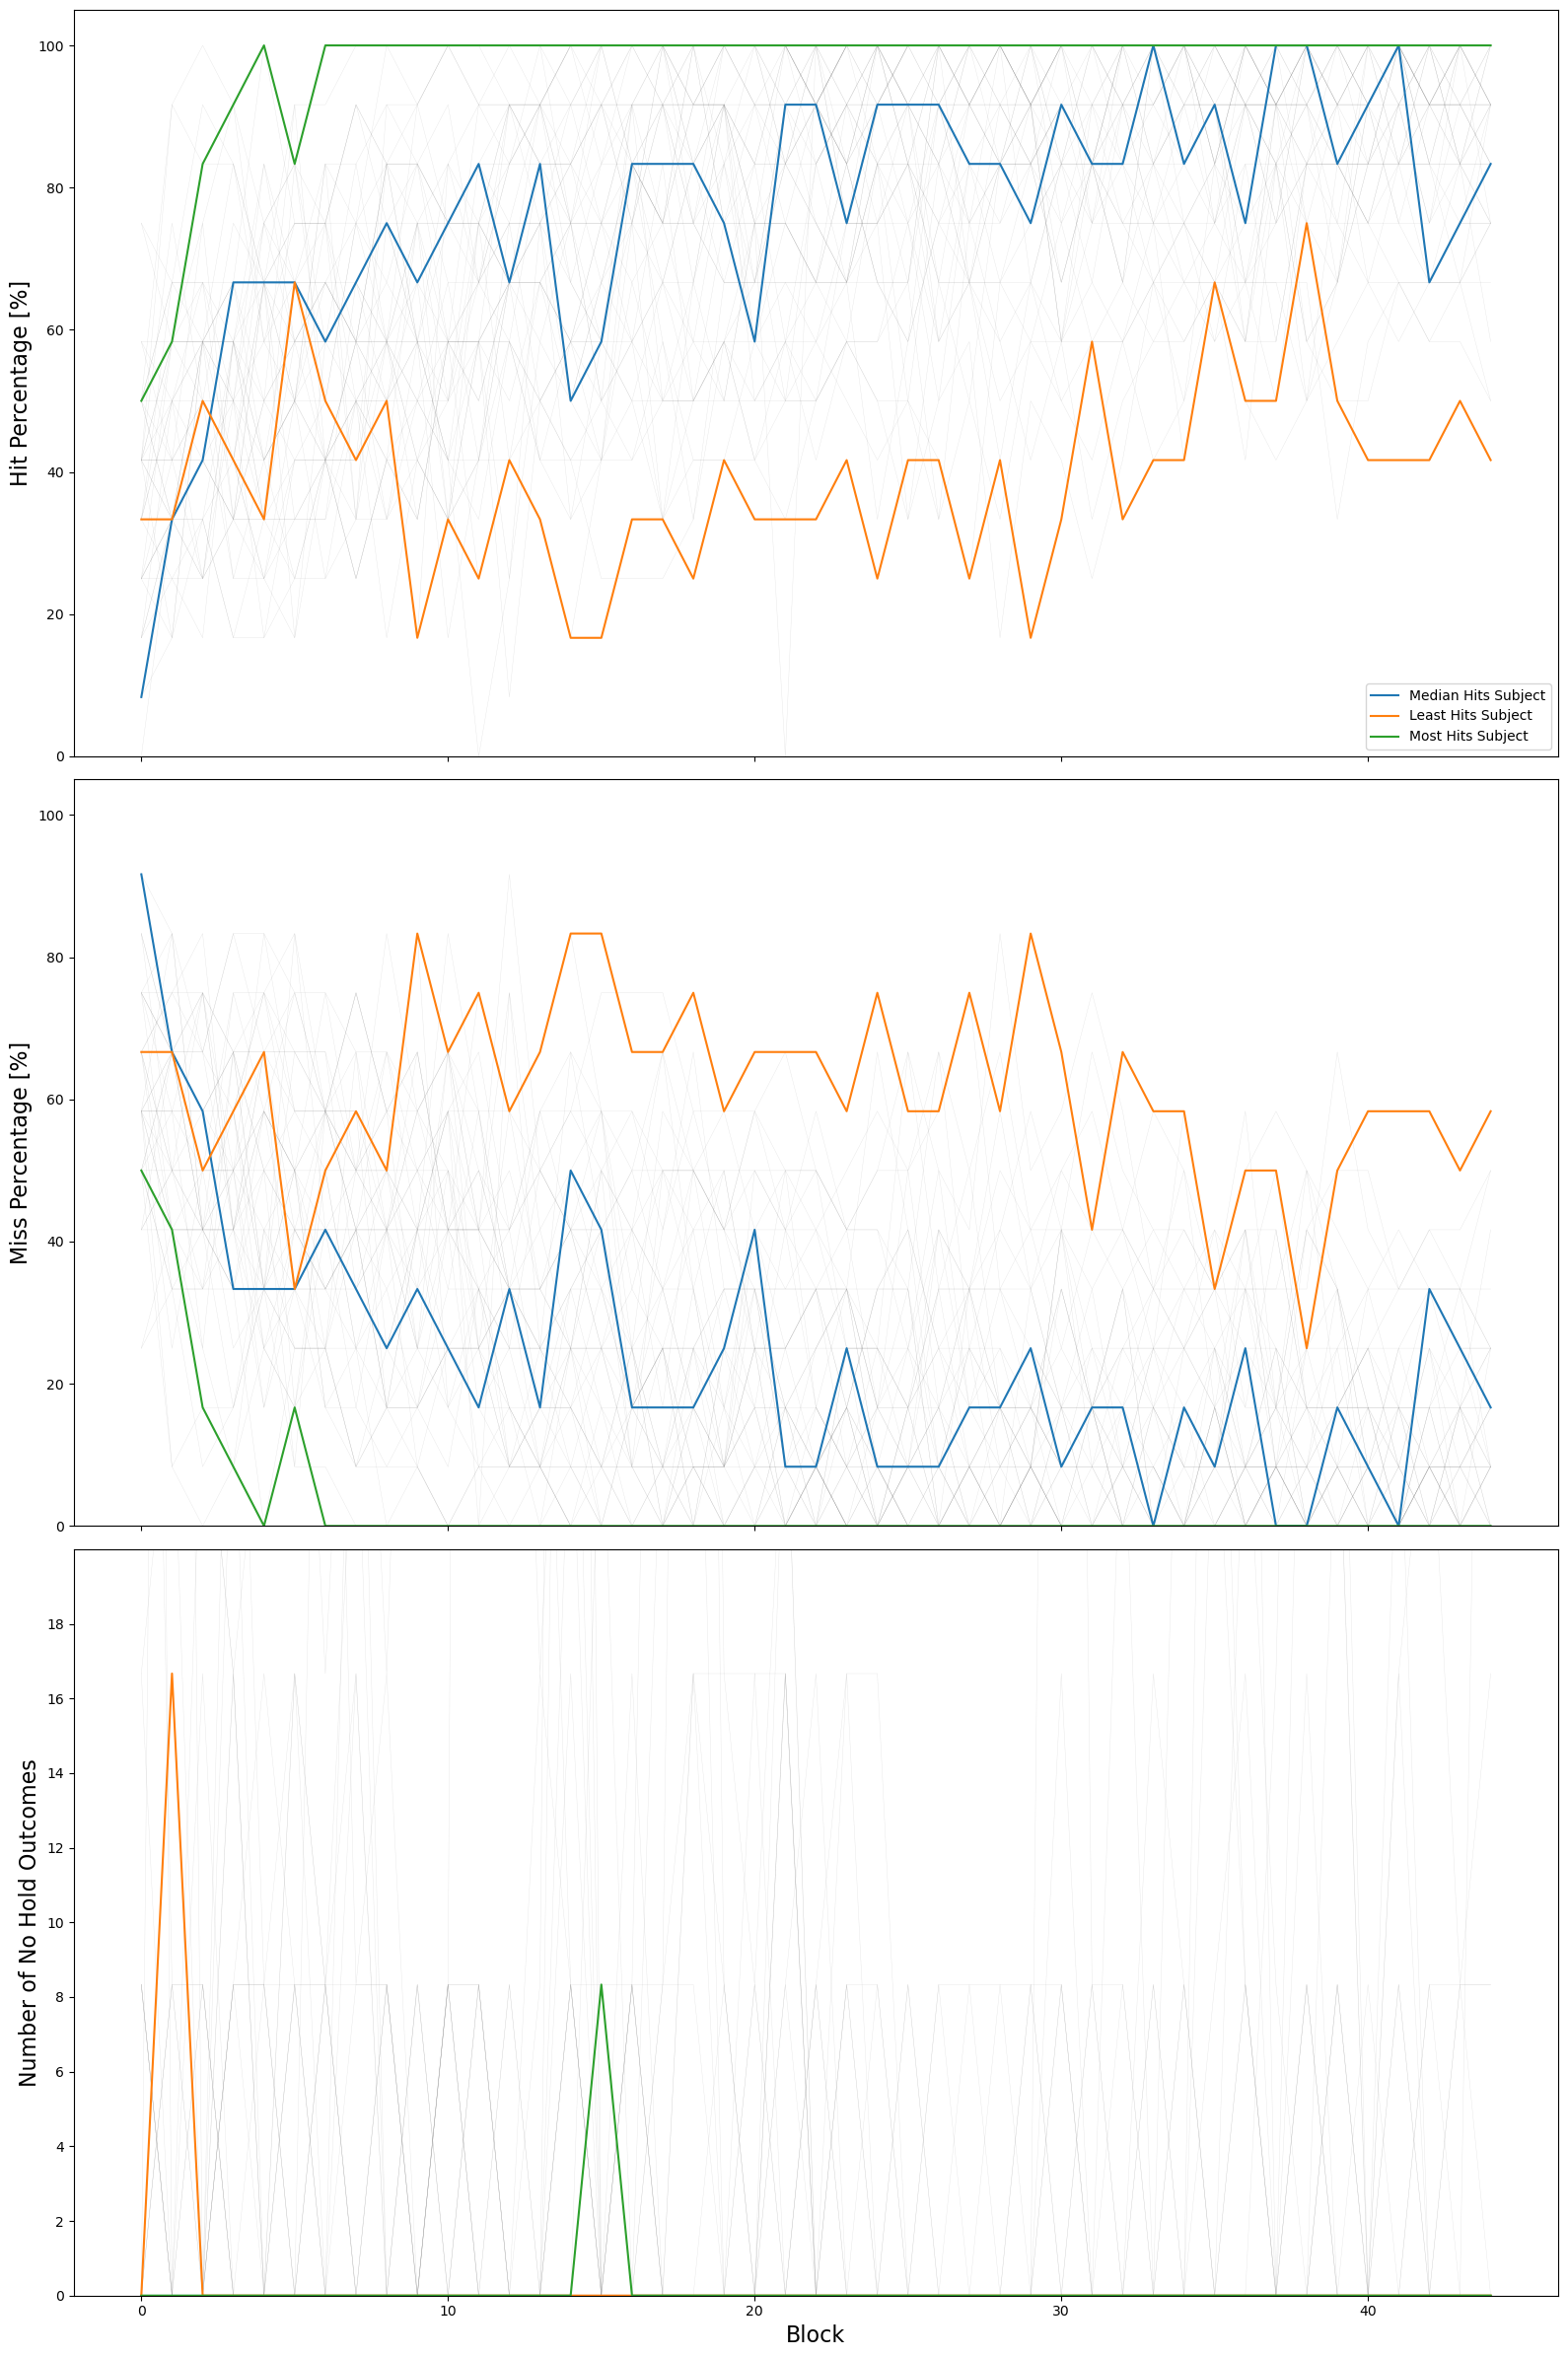

In [6]:
outcomes_fig, (hit_ax, miss_ax, nohold_ax) = plt.subplots(3,1,figsize=(16,24),sharex=True)

for sub in counts.keys():
    if sub == most_hit_subject:
        hit_ax.plot([h["hits"]/12*100 for h in counts[sub]][:45],label="Most Hits Subject",zorder=100)
        miss_ax.plot([h["misses"]/12*100 for h in counts[sub]][:45],zorder=100)
        nohold_ax.plot([h["noholds"]/12*100 for h in counts[sub]][:45],zorder=100)
    elif sub == median_hit_subject:
        hit_ax.plot([h["hits"]/12*100 for h in counts[sub]][:45],label="Median Hits Subject",zorder=100)
        miss_ax.plot([h["misses"]/12*100 for h in counts[sub]][:45],zorder=100)
        nohold_ax.plot([h["noholds"]/12*100 for h in counts[sub]][:45],zorder=100)
    elif sub == least_hit_subject:
        hit_ax.plot([h["hits"]/12*100 for h in counts[sub]][:45],label="Least Hits Subject",zorder=100)
        miss_ax.plot([h["misses"]/12*100 for h in counts[sub]][:45],zorder=100)
        nohold_ax.plot([h["noholds"]/12*100 for h in counts[sub]][:45],zorder=100)
    else:
        hit_ax.plot([h["hits"]/12*100 for h in counts[sub]][:45], "grey", linewidth=0.3,alpha=0.2)
        miss_ax.plot([h["misses"]/12*100 for h in counts[sub]][:45], "grey", linewidth=0.3,alpha=0.2)
        nohold_ax.plot([h["noholds"]/12*100 for h in counts[sub]][:45], "grey", linewidth=0.3,alpha=0.2)

# hit_ax.set_title("Hits over Blocks", fontsize=16)
hit_ax.set_ylim([0,105])
hit_ax.set_ylabel("Hit Percentage [%]", fontsize=16)
hit_ax.legend(loc="lower right")

# miss_ax.set_title("Misses over Blocks", fontsize=16)
miss_ax.set_ylim([0,105])
miss_ax.set_ylabel("Miss Percentage [%]", fontsize=16)

# nohold_ax.set_title("No Holds over Blocks", fontsize=16)
nohold_ax.set_ylabel("Number of No Hold Outcomes", fontsize=16)
nohold_ax.set_ylim([0,20])
nohold_ax.set_yticks(list(range(0,20,2)))
nohold_ax.set_xlabel("Block", fontsize=16)

outcomes_fig.tight_layout()

In [ ]:
outcomes_fig.savefig("/Users/spencer/motor-control/thesis/images/data_analysis2023/outcomes.pdf", dpi=300, format="pdf")

## hit percentages per target

## plot and fit the hit reach times

In [7]:
def avg(l):
    if len(l) == 0:
        return None
    else:
        return sum(l)/len(l)


def drop_nones(l, return_indices=False):
    new_l = []
    enum = []
    for i, e in enumerate(l):
        if not e is None:
            new_l.append(e)
            enum.append(i)
    if return_indices:
        return enum, new_l
    else:
        return new_l

In [8]:
avg_reach_times = {}
for s in subjects:
    avg_reach_times[s.name] = []
    for session_num in range(45):
        # outcomes by session
        outcomes = s.get_session_outcomes(collection_name, session_num)
        # sort by trial number
        sorted_outcomes = sorted(outcomes.items(), key=lambda d: d[0].split("_")[1])
        # mean hit reach time over trials in a session
        avg_reach_times[s.name].append(avg([d[1]["reach_time"] for d in sorted_outcomes if d[1]["outcome"]=="Hit"]))


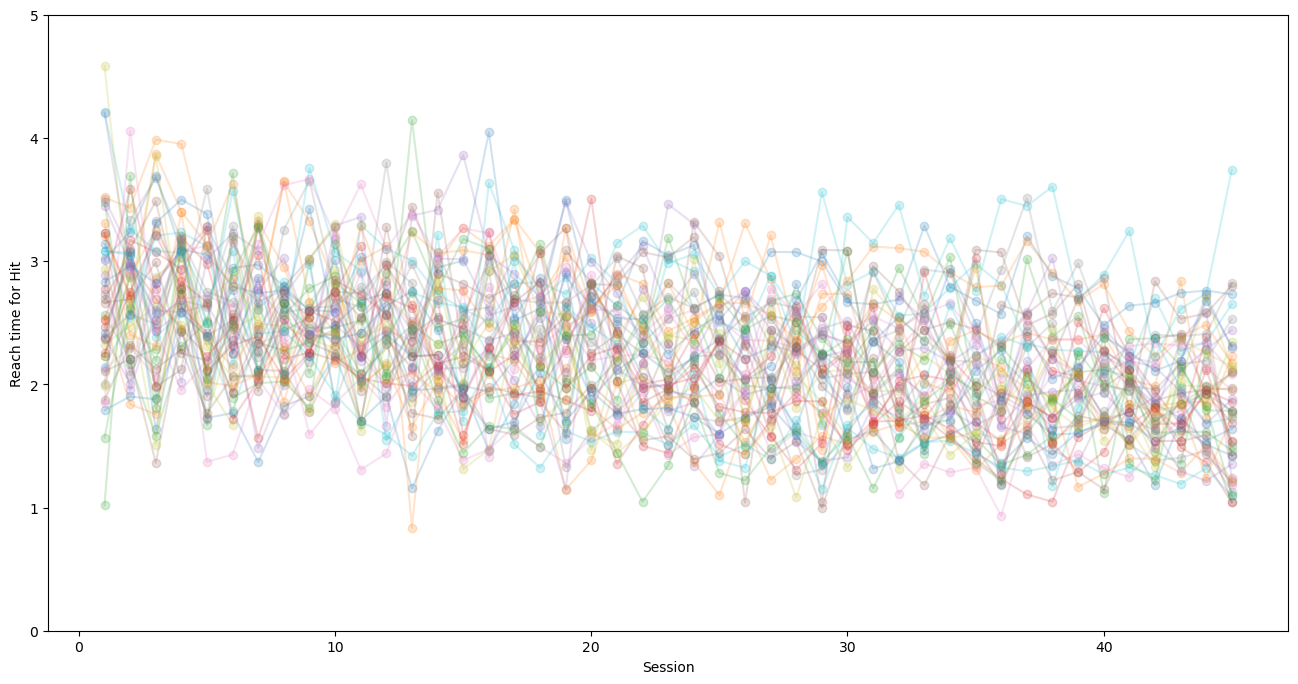

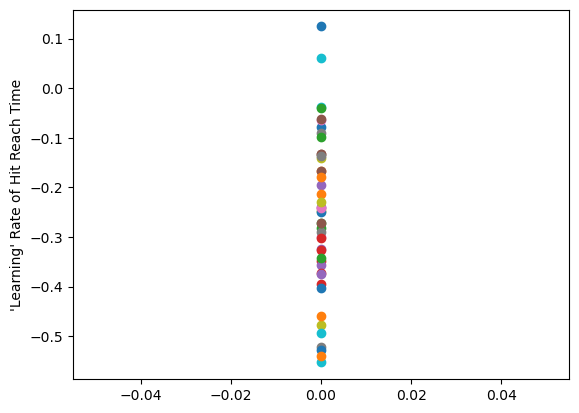

In [9]:
learning_rates = {}
fig, ax = plt.subplots(1,1, figsize=[16,8])
for s in subjects:
    t = avg_reach_times[s.name]
    x, y = drop_nones(t, return_indices=True)
    x = [xx+1 for xx in x]
    ax.plot(x, y,'o-',alpha=0.2)
    params = curve_fit(analysis.log, x,  y)[0]
    # ax.plot(x, analysis.log(x, params[0], params[1]))
    learning_rates[s.name] = params[1]
ax.set_ylim([0,5])
ax.set_ylabel("Reach time for Hit")
ax.set_xlabel("Session")

plt.figure()
for lr in list(learning_rates.values()):
    plt.plot(0,lr,'o')
    plt.ylabel("'Learning' Rate of Hit Reach Time")

# trajectory path length over trials

In [26]:
def get_session_nums(s):
    return list(s.behavior[collection_name].keys())

def get_trial_nums(s, collection_name, session_num, skip_list=["No Hold"]):
    return [k for k, v in s.get_session_outcomes(collection_name, session_num).items() if not v["outcome"] in skip_list]
    
print(get_session_nums(subjects[0]))
print(get_trial_nums(s, collection_name, 0))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44']
['trial_0', 'trial_1', 'trial_2', 'trial_3', 'trial_4', 'trial_5', 'trial_6', 'trial_7', 'trial_8', 'trial_9', 'trial_10', 'trial_11']


- go through the behavior file `get_session_outcomes` -- build a dict from this, number of trials, which are no-holds
- for each trial, add the filenames for emg, behavior, etc as a value in that dict -- this dict then becomes the trial?
- make trial objects which are built based on the behavior outcomes file-- put the specific filenames in each of these to later pull from s3

In [ ]:


    # def get_center_hold_outcomes(self, collection_name):
    #     self.outcomes = {}
    #     for session_num in range(45):
    #         hits, misses, noholds, outcomes = self.get_session_outcomes(collection_name, str(session_num))
    #         self.outcomes[str(session_num)] = {}
    #         self.outcomes[str(session_num)]["outcomes"] = outcomes
    #         self.outcomes[str(session_num)]["hits"] = hits
    #         self.outcomes[str(session_num)]["misses"] = misses
    #         self.outcomes[str(session_num)]["noholds"] = noholds
    #         self.outcomes[str(session_num)]["hit_percentage"] = analysis.calculate_hit_percentage(hits)


In [47]:
s = subject.Subject("aeron")
for k, v in s.get_session_outcomes(collection_name, 16).items():
    print(k,v)

created emg_olympics for aeron
trial_0 {'outcome': 'Hit', 'target': [0.87, -0.5], 'hold_time': 0.7666667, 'reach_time': 0.8}
trial_1 {'outcome': 'Miss', 'target': [-0.87, -0.5], 'hold_time': 0.7666667, 'reach_time': None}
trial_2 {'outcome': 'Miss', 'target': [-0.5, -0.87], 'hold_time': 0.7666667, 'reach_time': None}
trial_3 {'outcome': 'Hit', 'target': [-1.0, 0.0], 'hold_time': 1.466667, 'reach_time': 2.166667}
trial_4 {'outcome': 'Hit', 'target': [0.5, 0.87], 'hold_time': 1.466667, 'reach_time': 0.6666667}
trial_5 {'outcome': 'Hit', 'target': [0.0, 1.0], 'hold_time': 1.1, 'reach_time': 0.7666667}
trial_6 {'outcome': 'Hit', 'target': [0.0, -1.0], 'hold_time': 2.266667, 'reach_time': 4.133333}
trial_7 {'outcome': 'Hit', 'target': [0.87, 0.5], 'hold_time': 3.083333, 'reach_time': 1.716667}
trial_8 {'outcome': 'Hit', 'target': [0.5, -0.87], 'hold_time': 3.05, 'reach_time': 0.6833333}
trial_9 {'outcome': 'Hit', 'target': [-0.87, 0.5], 'hold_time': 0.7666667, 'reach_time': 2.766667}
trial_

In [33]:
# path lengths per trial over subjects
for s in subjects:
    if s.name == "aeron":
        lengths = []
        # get sessions
        for session_num in get_session_nums(s):
                # get Hit and Miss trials
                for trial_num in get_trial_nums(s, collection_name, session_num, skip_list=["No Hold"]):
                    print(s.name, session_num, trial_num)
                    t = s.get_center_hold_trajectory(collection_name, s.name, session_num, int(trial_num.split("_")[-1]))[:,-2:]
                    # use the hold time + response time instead of this 250
                    lengths.append(path_length(t[250:,:]))
            # plt.plot(lengths,'o-',alpha=0.2)

aeron 0 trial_0
aeron 0 trial_1
aeron 0 trial_2
aeron 0 trial_3
aeron 0 trial_4
aeron 0 trial_5
aeron 0 trial_6
aeron 0 trial_7
aeron 0 trial_8
aeron 0 trial_9
aeron 0 trial_10
aeron 0 trial_11
aeron 1 trial_0
aeron 1 trial_1
aeron 1 trial_2
aeron 1 trial_3
aeron 1 trial_4
aeron 1 trial_5
aeron 1 trial_6
aeron 1 trial_7
aeron 1 trial_8
aeron 1 trial_9
aeron 1 trial_10
aeron 1 trial_11
aeron 2 trial_0
aeron 2 trial_1
aeron 2 trial_2
aeron 2 trial_3
aeron 2 trial_4
aeron 2 trial_5
aeron 2 trial_6
aeron 2 trial_7
aeron 2 trial_8
aeron 2 trial_9
aeron 2 trial_10
aeron 2 trial_11
aeron 3 trial_0
aeron 3 trial_1
aeron 3 trial_2
aeron 3 trial_3
aeron 3 trial_4
aeron 3 trial_5
aeron 3 trial_6
aeron 3 trial_7
aeron 3 trial_8
aeron 3 trial_9
aeron 3 trial_10
aeron 3 trial_11
aeron 4 trial_0
aeron 4 trial_1
aeron 4 trial_2
aeron 4 trial_3
aeron 4 trial_4
aeron 4 trial_5
aeron 4 trial_6
aeron 4 trial_7
aeron 4 trial_8
aeron 4 trial_9
aeron 4 trial_10
aeron 4 trial_11
aeron 5 trial_0
aeron 5 trial_

ValueError: Unable to find object with prefix rawdata/emg_olympics/aeron/center_hold/session_16/12_behavior_

# trajectory segments over trials

In [ ]:
def path_length(a):
    assert a.shape[0] > a.shape[1], f"array with shape {a.shape} should be transposed."
    assert a.shape[1] == 2, f"array with shape {a.shape} must be two-dimensional"
    return np.sum(np.sqrt(np.sum(np.diff(a, axis=0)**2,axis=1)))

def get_zero_crossings(x):
    # find the indices where the velocity of the trajectory changes sign
    assert len(x.shape) == 1
    return np.where(np.diff(np.sign(np.diff(x))))[0]

def get_segment_indices(t, velocity_threshold_percentage=5, min_crossing_interval=5):
    assert t.shape[1] == 2, f"trajectory has incorrect shape: {t.shape}"
    zero_crosses_x = get_zero_crossings(t[:,0])
    zero_crosses_y = get_zero_crossings(t[:,1])
    # combine vx and vy together
    zero_crosses_xy = np.concatenate((zero_crosses_x, zero_crosses_y))
    # sort the x and y indices
    zero_crosses_xy.sort()
    zc_clean = []
    vel_lim = np.max(np.abs(t))*(velocity_threshold_percentage/100)
    for i, z in enumerate(zero_crosses_xy[:-1]):
        # reject crossing if the neighborhood is low velocity
        if np.max(np.abs(t[z-min([5,z]):z+5, :])) > vel_lim:
            # reject the crossing if it's not spaced out above a threshold
            if abs(z - zero_crosses_xy[i+1]) > min_crossing_interval: 
                zc_clean.append(z)
    return zc_clean
def sorted_dict_items_by_key(d):
    return [(k, v) for k, v in sorted(d.items(), key= lambda b: b[0])]

d = {"1":"blah", "4":"foo", "-4": "bar"}
sorted_dict_items_by_key(d)

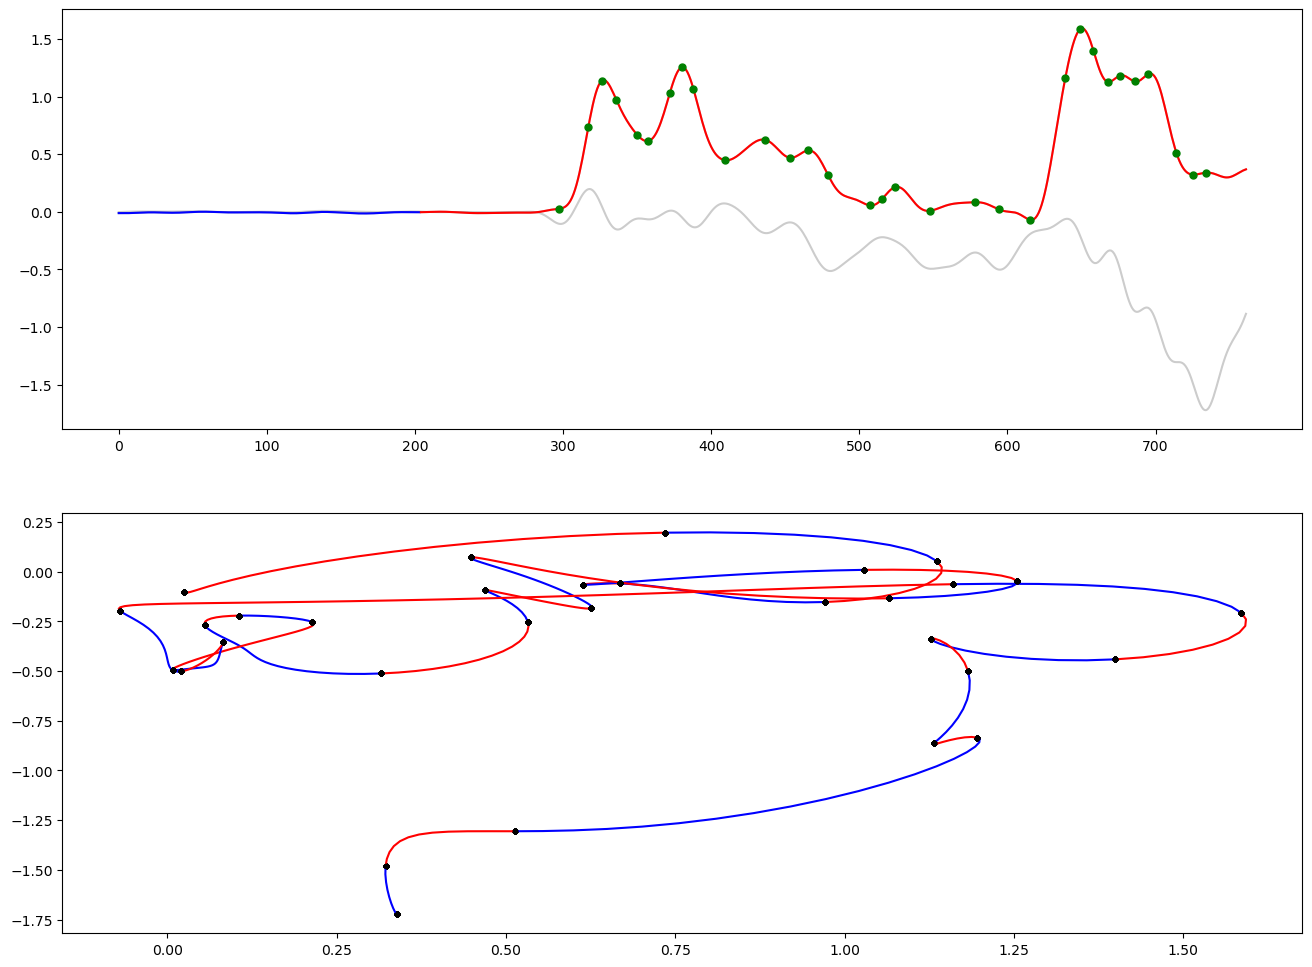

In [76]:
reaction_time_delay = 50 # 200 ms?
sample_rate = 200

session_num = 9
trial_num = 3
# hold_time is the time until the target appears (subjects have thus held for 0.75s within a possible 3.5s window)

# for each subject
for s in subjects[2:3]:
    # get behavior, including hold and reach times
    b = s.get_session_outcomes(collection_name, session_num)
    # for each outcome
    for trial, val in sorted_dict_items_by_key(b):
        # ignore no hold trials
        if val["outcome"] == "Hit":
            # get trial number
            trial_num = int(trial.split("_")[-1])
            # get the trajectory for that trial
            t = s.get_center_hold_trajectory(collection_name, s.name, session_num, trial_num)[:,-2:]
            # grab the hold time
            hold_time = val["hold_time"]
            hold_steps = int(np.ceil(hold_time*sample_rate)) + reaction_time_delay
            # find it's length 
            length = path_length(t[hold_steps:,:])
            # find its segments
            segment_indices = get_segment_indices(t[hold_steps:,:])

            # test plot
            fig, axes = plt.subplots(2,1,figsize=(16,12))
            axes[0].plot(t[:,0], "k", alpha=0.2)
            axes[0].plot(t[:,1], "k", alpha=0.2)
            axes[0].plot(range(hold_steps), t[:hold_steps,0], "b")
            axes[0].plot(range(hold_steps, t.shape[0]), t[hold_steps:,0], "r")
            axes[0].plot(segment_indices, t[segment_indices,0], "go",markersize=5)

            c = "b"
            for i, zc in enumerate(segment_indices[:-1]):
                if c == "r":
                    c = "b"
                else:
                    c = "r"
                axes[1].plot(t[zc:segment_indices[i+1]+1,0],t[zc:segment_indices[i+1]+1,1], c)
                axes[1].plot(t[segment_indices,0], t[segment_indices,1], "ko", markersize=3)

            break
    break


In [ ]:
zc_clean = get_segment_indices(t)

fig, axes = plt.subplots(2,1,figsize=(28,12))

axes[0].plot(t[:,0])
axes[0].plot(t[:,1])

# axes[1].plot(np.diff(t[:,0]))
# axes[1].plot(zero_crosses_x, np.zeros_like(zero_crosses_x), 'ro')
# axes[1].plot(np.diff(t[:,1]))
# axes[1].plot(zero_crosses_y, np.zeros_like(zero_crosses_y), 'ko')

axes[1].plot(np.diff(t[:,0]))
axes[1].plot(np.diff(t[:,1]))
axes[1].plot(zc_clean, np.zeros_like(zc_clean), 'bo')
axes[1].plot(zc_clean, np.zeros_like(zc_clean), 'bo')

plt.figure()
plt.plot(t[:,0], t[:,1])
plt.plot(t[zc_clean,0], t[zc_clean,1], "ro")

plt.figure()
c = "b"
for i, zc in enumerate(zc_clean[:-1]):
    if c == "r":
        c = "b"
    else:
        c = "r"
    plt.plot(t[zc:zc_clean[i+1]+1,0],t[zc:zc_clean[i+1]+1,1], c)
    plt.plot(t[zc_clean,0], t[zc_clean,1], "ko", markersize=3)
# plt.xlim([1,1.5])
# plt.ylim([-0.2,0])

- if zero crossings are within ~50, take the average of them
- if the velocity on either side of the crossing is less than ~5% of the max velocity, ignore

measures of performance
- number of segments per time?
- 